# Data description & Problem statement: 
The dataset here is a sample of the transactions made in a retail store. The store wants to know better the customer purchase behaviour against different products. Specifically, here the problem is a Regression problem where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables. The data set has 550067 rows and 11 variables.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build the ensemble method (i.e. Bagging model and Stacked model) individually
   # Model Evaluation: 
- Evaluate the Ensemble models with Cross-Validation technique, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('train.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [3]:
df.fillna(999, inplace=True)

In [4]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# for i in ['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years']:
for i in ['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years',
          'Gender', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3' ]:
    encode_text_index(df, i)

In [5]:
df.head(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1026,3372,1,5,19,2,3,0,0,0,12,19142
1,5043,2263,0,3,11,1,1,0,0,13,12,15513
2,407,1071,0,3,0,0,2,1,7,13,15,7802
3,484,162,1,1,4,0,3,0,0,13,12,15455
4,1953,21,1,1,4,1,0,0,5,6,12,4492


In [6]:
X=df.drop(['Purchase'], axis=1)
y=np.log(df['Purchase'])

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Re-scaling & Polynomial Interactions:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

#scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
#X_train=scalor_X.transform(pd.DataFrame(X_train))
#X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

# 1)  Bagging meta-estimator with XGBoost:

In [6]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import BaggingRegressor

model=XGBRegressor(gamma= 0, max_depth= 3, min_child_weight= 1)

bag=BaggingRegressor(model, n_estimators = 100, max_samples=0.9, max_features=0.9, random_state=42)
kfold=KFold(n_splits=4, shuffle=True, random_state=42)
scores=cross_val_score(bag, X_train, y_train, cv=kfold)

print(scores, "\n")
print("AUC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.86880861 0.87332533 0.90963991 0.90171472] 

AUC Accuracy: 0.89 (+/- 0.02)


In [7]:
# Grid-Search for the best Bagging parameters: 

from sklearn.model_selection import GridSearchCV
param={'max_samples':[0.5, 0.7, 0.8, 0.9, 1], 'max_features':[0.5, 0.7, 0.9, 1]}

kfold=KFold(n_splits=4, shuffle=True, random_state=42)
grid_search=GridSearchCV(BaggingRegressor(model, n_estimators = 50, random_state=42), param, cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_samples,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,1.942675,0.005850,0.034841,0.001925,0.9,0.8,"{'max_features': 0.9, 'max_samples': 0.8}",0.871666,0.878615,0.909368,0.901571,0.890202,0.015607,1,0.963712,0.958644,0.954332,0.955940,0.958157,0.003558
13,1.970059,0.010512,0.035559,0.002778,0.9,0.9,"{'max_features': 0.9, 'max_samples': 0.9}",0.871076,0.876845,0.910993,0.902037,0.890127,0.016706,2,0.965880,0.960757,0.957741,0.959062,0.960860,0.003089
11,1.941488,0.016813,0.037520,0.003982,0.9,0.7,"{'max_features': 0.9, 'max_samples': 0.7}",0.870101,0.879970,0.908406,0.901772,0.889960,0.015605,3,0.961141,0.955889,0.950807,0.952220,0.955014,0.003994


In [8]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'max_features': 0.9, 'max_samples': 0.8}
Best validation accuracy:  0.89 (+/- 0.02)
Test score:  0.89


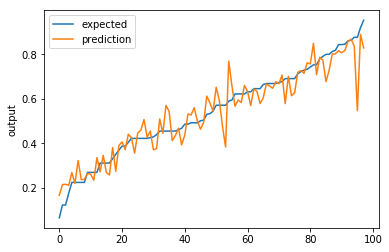

In [9]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2.76164627400196


# 2) Stacked Regressor with XGBoost:

In [7]:
import xgboost
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

reg_1=XGBRegressor(max_depth= 12, min_child_weight=10, subsample=0.7, n_estimators=100)
reg_2=XGBRegressor(max_depth= 8, min_child_weight=10, subsample=0.7, n_estimators=200)
reg_3=XGBRegressor(max_depth= 6, min_child_weight=10, subsample=0.7, n_estimators=300)

meta_reg=XGBRegressor(max_depth= 12, min_child_weight=5, subsample=0.7, n_estimators=200)

stack=StackingRegressor(regressors=[reg_1, reg_2, reg_3], meta_regressor= meta_reg, use_features_in_secondary=True)

scores=cross_val_score(stack, X_train, y_train)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.7847752  0.78362    0.78646803] 

Accuracy: 0.78 (+/- 0.00)


In [9]:
stack.fit(X_train, y_train)

StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=5, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7),
         refit=True,
         regressors=[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
  ...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)],
         store_train_meta_features=False, use_features_in_secondary=True,
         verbose=0)

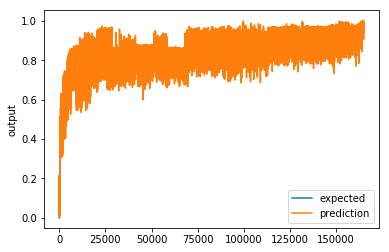

In [10]:
# Plot the Lift Chart:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=stack.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2636.5354431419178


In [12]:
# Grid-Search for the best model parameters: 

from sklearn.model_selection import GridSearchCV

param={'meta-ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000]}
#param={'meta-xgbregressor__max_depth':[2, 3, 4, 5], 'meta-xgbregressor__min_child_weight':[1, 2, 3, 4], 
#      'meta-xgbregressor__gamma': [ 0, 0.01, 0.05, 0.1]}

kfold=KFold(n_splits=5, shuffle=True, random_state=42)
grid_search=GridSearchCV(StackingRegressor([reg1, reg2, reg3], meta_regressor= meta_reg), param, cv=kfold) 

grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_meta-ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,0.146101,0.002646,0.005820,0.001818,1,{'meta-ridge__alpha': 1},0.860384,0.879283,0.903379,0.880925,...,0.887986,0.019631,1,0.976794,0.975742,0.973366,0.975252,0.972579,0.974746,0.001552
4,0.153816,0.006850,0.005802,0.002233,0.5,{'meta-ridge__alpha': 0.5},0.854796,0.880561,0.895593,0.882475,...,0.886704,0.021423,2,0.981636,0.980933,0.979368,0.979075,0.979297,0.980062,0.001027
3,0.153419,0.008415,0.005556,0.002004,0.1,{'meta-ridge__alpha': 0.1},0.833876,0.872018,0.885271,0.884816,...,0.877331,0.025208,3,0.989314,0.985638,0.985957,0.987929,0.988202,0.987408,0.001398


In [13]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'meta-ridge__alpha': 1}
Best validation accuracy:  0.89 (+/- 0.02)
Test score:  0.91


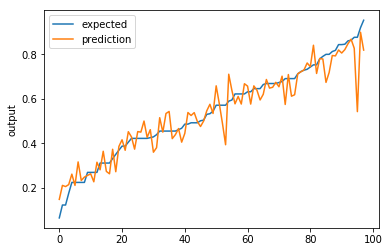

In [14]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2.640357548516481
